# Project: Identify Customer Segments

In this project, you will apply unsupervised learning techniques to identify segments of the population that form the core customer base for a mail-order sales company in Germany. These segments can then be used to direct marketing campaigns towards audiences that will have the highest expected rate of returns. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

This notebook will help you complete this task by providing a framework within which you will perform your analysis steps. In each step of the project, you will see some text describing the subtask that you will perform, followed by one or more code cells for you to complete your work. **Feel free to add additional code and markdown cells as you go along so that you can explore everything in precise chunks.** The code cells provided in the base template will outline only the major tasks, and will usually not be enough to cover all of the minor tasks that comprise it.

It should be noted that while there will be precise guidelines on how you should handle certain tasks in the project, there will also be places where an exact specification is not provided. **There will be times in the project where you will need to make and justify your own decisions on how to treat the data.** These are places where there may not be only one way to handle the data. In real-life tasks, there may be many valid ways to approach an analysis task. One of the most important things you can do is clearly document your approach so that other scientists can understand the decisions you've made.

At the end of most sections, there will be a Markdown cell labeled **Discussion**. In these cells, you will report your findings for the completed section, as well as document the decisions that you made in your approach to each subtask. **Your project will be evaluated not just on the code used to complete the tasks outlined, but also your communication about your observations and conclusions at each stage.**

In [2]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
from sklearn.preprocessing import StandardScaler, Imputer
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

# magic word for producing visualizations in notebook
%matplotlib inline

'''
Import note: The classroom currently uses sklearn version 0.19.
If you need to use an imputer, it is available in sklearn.preprocessing.Imputer,
instead of sklearn.impute as in newer versions of sklearn.
'''

'\nImport note: The classroom currently uses sklearn version 0.19.\nIf you need to use an imputer, it is available in sklearn.preprocessing.Imputer,\ninstead of sklearn.impute as in newer versions of sklearn.\n'

### Step 0: Load the Data

There are four files associated with this project (not including this one):

- `Udacity_AZDIAS_Subset.csv`: Demographics data for the general population of Germany; 891211 persons (rows) x 85 features (columns).
- `Udacity_CUSTOMERS_Subset.csv`: Demographics data for customers of a mail-order company; 191652 persons (rows) x 85 features (columns).
- `Data_Dictionary.md`: Detailed information file about the features in the provided datasets.
- `AZDIAS_Feature_Summary.csv`: Summary of feature attributes for demographics data; 85 features (rows) x 4 columns

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. You will use this information to cluster the general population into groups with similar demographic properties. Then, you will see how the people in the customers dataset fit into those created clusters. The hope here is that certain clusters are over-represented in the customers data, as compared to the general population; those over-represented clusters will be assumed to be part of the core userbase. This information can then be used for further applications, such as targeting for a marketing campaign.

To start off with, load in the demographics data for the general population into a pandas DataFrame, and do the same for the feature attributes summary. Note for all of the `.csv` data files in this project: they're semicolon (`;`) delimited, so you'll need an additional argument in your [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call to read in the data properly. Also, considering the size of the main dataset, it may take some time for it to load completely.

Once the dataset is loaded, it's recommended that you take a little bit of time just browsing the general structure of the dataset and feature summary file. You'll be getting deep into the innards of the cleaning in the first major step of the project, so gaining some general familiarity can help you get your bearings.

In [3]:
# Load in the general demographics data.
azdias = pd.read_csv('Udacity_AZDIAS_Subset.csv', delimiter =';')

# Load in the feature summary file.
feat_info = pd.read_csv('AZDIAS_Feature_Summary.csv', delimiter = ';')

In [3]:
# Check the structure of the data after it's loaded (e.g. print the number of
# rows and columns, print the first few rows).

azdias.info()
azdias.head()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891221 entries, 0 to 891220
Data columns (total 85 columns):
AGER_TYP                 891221 non-null int64
ALTERSKATEGORIE_GROB     891221 non-null int64
ANREDE_KZ                891221 non-null int64
CJT_GESAMTTYP            886367 non-null float64
FINANZ_MINIMALIST        891221 non-null int64
FINANZ_SPARER            891221 non-null int64
FINANZ_VORSORGER         891221 non-null int64
FINANZ_ANLEGER           891221 non-null int64
FINANZ_UNAUFFAELLIGER    891221 non-null int64
FINANZ_HAUSBAUER         891221 non-null int64
FINANZTYP                891221 non-null int64
GEBURTSJAHR              891221 non-null int64
GFK_URLAUBERTYP          886367 non-null float64
GREEN_AVANTGARDE         891221 non-null int64
HEALTH_TYP               891221 non-null int64
LP_LEBENSPHASE_FEIN      886367 non-null float64
LP_LEBENSPHASE_GROB      886367 non-null float64
LP_FAMILIE_FEIN          886367 non-null float64
LP_FAMILIE_GROB          886367 n

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,-1,2,1,2.0,3,4,3,5,5,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,-1,1,2,5.0,1,5,2,5,4,5,...,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,-1,3,2,3.0,1,4,1,2,3,5,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,2,4,2,2.0,4,2,5,2,1,2,...,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,-1,3,1,5.0,4,3,4,1,3,2,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0


In [4]:
feat_info.info()
feat_info.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 85 entries, 0 to 84
Data columns (total 4 columns):
attribute             85 non-null object
information_level     85 non-null object
type                  85 non-null object
missing_or_unknown    85 non-null object
dtypes: object(4)
memory usage: 2.7+ KB


,attribute,information_level,type,missing_or_unknown
0,AGER_TYP,person,categorical,"[-1,0]"
1,ALTERSKATEGORIE_GROB,person,ordinal,"[-1,0,9]"
2,ANREDE_KZ,person,categorical,"[-1,0]"
3,CJT_GESAMTTYP,person,categorical,[0]
4,FINANZ_MINIMALIST,person,ordinal,[-1]


> **Tip**: Add additional cells to keep everything in reasonably-sized chunks! Keyboard shortcut `esc --> a` (press escape to enter command mode, then press the 'A' key) adds a new cell before the active cell, and `esc --> b` adds a new cell after the active cell. If you need to convert an active cell to a markdown cell, use `esc --> m` and to convert to a code cell, use `esc --> y`. 

## Step 1: Preprocessing

### Step 1.1: Assess Missing Data

The feature summary file contains a summary of properties for each demographics data column. You will use this file to help you make cleaning decisions during this stage of the project. First of all, you should assess the demographics data in terms of missing data. Pay attention to the following points as you perform your analysis, and take notes on what you observe. Make sure that you fill in the **Discussion** cell with your findings and decisions at the end of each step that has one!

#### Step 1.1.1: Convert Missing Value Codes to NaNs
The fourth column of the feature attributes summary (loaded in above as `feat_info`) documents the codes from the data dictionary that indicate missing or unknown data. While the file encodes this as a list (e.g. `[-1,0]`), this will get read in as a string object. You'll need to do a little bit of parsing to make use of it to identify and clean the data. Convert data that matches a 'missing' or 'unknown' value code into a numpy NaN value. You might want to see how much data takes on a 'missing' or 'unknown' code, and how much data is naturally missing, as a point of interest.

**As one more reminder, you are encouraged to add additional cells to break up your analysis into manageable chunks.**

In [5]:
#checking the current status of null values in dataframe
azdias.isnull().sum().head()

AGER_TYP                   0
ALTERSKATEGORIE_GROB       0
ANREDE_KZ                  0
CJT_GESAMTTYP           4854
FINANZ_MINIMALIST          0
dtype: int64

In [6]:
#looking at the missing_or_unknown values in feat_info
feat_info['missing_or_unknown']

0       [-1,0]
1     [-1,0,9]
2       [-1,0]
3          [0]
4         [-1]
5         [-1]
6         [-1]
7         [-1]
8         [-1]
9         [-1]
10        [-1]
11         [0]
12          []
13          []
14      [-1,0]
15         [0]
16         [0]
17         [0]
18         [0]
19         [0]
20         [0]
21      [-1,0]
22      [-1,0]
23         [0]
24      [-1,9]
25      [-1,9]
26      [-1,9]
27      [-1,9]
28      [-1,9]
29      [-1,9]
        ...   
55        [-1]
56        [-1]
57      [-1,X]
58        [XX]
59     [-1,XX]
60        [-1]
61        [-1]
62        [-1]
63        [-1]
64      [-1,0]
65      [-1,0]
66        [-1]
67        [-1]
68        [-1]
69          []
70      [-1,0]
71          []
72          []
73      [-1,0]
74          []
75        [-1]
76        [-1]
77        [-1]
78        [-1]
79      [-1,0]
80        [-1]
81        [-1]
82      [-1,9]
83      [-1,0]
84      [-1,9]
Name: missing_or_unknown, Length: 85, dtype: object

In [8]:
# Convert missing or unknown values from feat_info to nan in azdiaz
for i in range(len(feat_info)):
    # splitting values
    missing_values = re.sub('[\[|\]]', '',feat_info.iloc[i]['missing_or_unknown']).split(',')
    # returning values for int 
    if missing_values != ['']:
        missing_values = [np.int64(data) if (data!='X' and data!='XX') else data for data in missing_values]
        azdias = azdias.replace({feat_info.iloc[i]['attribute']: missing_values}, np.nan)

In [9]:
#checking that the NaNs are populated
azdias.isnull().sum().head()

AGER_TYP                685843
ALTERSKATEGORIE_GROB      2881
ANREDE_KZ                    0
CJT_GESAMTTYP             4854
FINANZ_MINIMALIST            0
dtype: int64

#### Step 1.1.2: Assess Missing Data in Each Column

How much missing data is present in each column? There are a few columns that are outliers in terms of the proportion of values that are missing. You will want to use matplotlib's [`hist()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.hist.html) function to visualize the distribution of missing value counts to find these columns. Identify and document these columns. While some of these columns might have justifications for keeping or re-encoding the data, for this project you should just remove them from the dataframe. (Feel free to make remarks about these outlier columns in the discussion, however!)

For the remaining features, are there any patterns in which columns have, or share, missing data?

In [9]:
# Perform an assessment of how much missing data there is in each column of the
# dataset.

check_missing_columns = azdias.isnull().sum() #checking for all columns with missing values
check_missing_columns.sort_values(inplace=True, ascending=False) #sorting from highest to lowest missing values by column
print(check_missing_columns)

TITEL_KZ                 889061
AGER_TYP                 685843
KK_KUNDENTYP             584612
KBA05_BAUMAX             476524
GEBURTSJAHR              392318
ALTER_HH                 310267
REGIOTYP                 158064
KKK                      158064
W_KEIT_KIND_HH           147988
KBA05_ANTG4              133324
KBA05_GBZ                133324
MOBI_REGIO               133324
KBA05_ANTG1              133324
KBA05_ANTG2              133324
KBA05_ANTG3              133324
PLZ8_GBZ                 116515
PLZ8_HHZ                 116515
PLZ8_BAUMAX              116515
PLZ8_ANTG4               116515
PLZ8_ANTG1               116515
PLZ8_ANTG3               116515
PLZ8_ANTG2               116515
SHOPPER_TYP              111196
VERS_TYP                 111196
HEALTH_TYP               111196
NATIONALITAET_KZ         108315
PRAEGENDE_JUGENDJAHRE    108164
KBA13_ANZAHL_PKW         105800
ANZ_HAUSHALTE_AKTIV       99611
CAMEO_INTL_2015           99352
                          ...  
RETOURTY

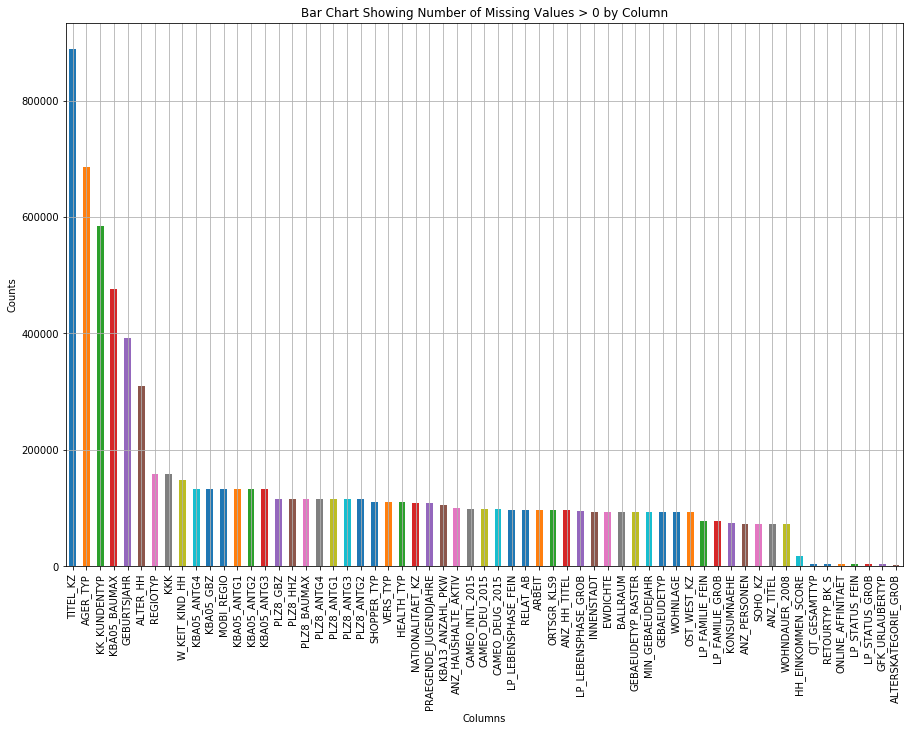

In [10]:
#plotting bar chart to show missing values
filter_missing_columns = check_missing_columns[check_missing_columns > 0]
filter_missing_columns.plot.bar(figsize=(15,10));
plt.xlabel('Columns')
plt.ylabel('Counts')
plt.title('Bar Chart Showing Number of Missing Values > 0 by Column')
plt.grid(True)
plt.show()

In [11]:
# Investigate patterns in the amount of missing data in each column.

missing_percent=check_missing_columns.sort_values(ascending=False)/float(len(azdias)) * 100
print(missing_percent)

TITEL_KZ                 99.757636
AGER_TYP                 76.955435
KK_KUNDENTYP             65.596749
KBA05_BAUMAX             53.468668
GEBURTSJAHR              44.020282
ALTER_HH                 34.813699
KKK                      17.735668
REGIOTYP                 17.735668
W_KEIT_KIND_HH           16.605084
KBA05_ANTG4              14.959701
KBA05_GBZ                14.959701
MOBI_REGIO               14.959701
KBA05_ANTG1              14.959701
KBA05_ANTG2              14.959701
KBA05_ANTG3              14.959701
PLZ8_ANTG4               13.073637
PLZ8_ANTG2               13.073637
PLZ8_ANTG1               13.073637
PLZ8_ANTG3               13.073637
PLZ8_BAUMAX              13.073637
PLZ8_GBZ                 13.073637
PLZ8_HHZ                 13.073637
SHOPPER_TYP              12.476816
VERS_TYP                 12.476816
HEALTH_TYP               12.476816
NATIONALITAET_KZ         12.153551
PRAEGENDE_JUGENDJAHRE    12.136608
KBA13_ANZAHL_PKW         11.871354
ANZ_HAUSHALTE_AKTIV 

In [12]:
print(missing_percent.describe())

count    85.000000
mean     11.054139
std      16.449815
min       0.000000
25%       0.000000
50%      10.451729
75%      13.073637
max      99.757636
dtype: float64


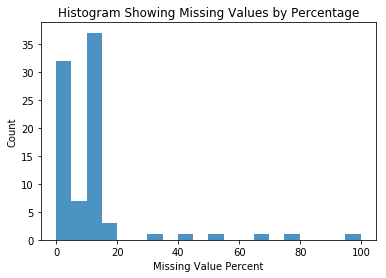

In [13]:
#histogram of missing values by percentage
plt.hist(missing_percent, bins=20, alpha = 0.8);
plt.xlabel('Missing Value Percent')
plt.ylabel('Count')
plt.title('Histogram Showing Missing Values by Percentage')
plt.show()

In [14]:
# Remove the outlier columns from the dataset. (You'll perform other data
# engineering tasks such as re-encoding and imputation later.)

#identifying outliers > 30%
outlier_missing_values = missing_percent[missing_percent > 30]
print("Outlier columns to be removed", outlier_missing_values)

Outlier columns to be removed TITEL_KZ        99.757636
AGER_TYP        76.955435
KK_KUNDENTYP    65.596749
KBA05_BAUMAX    53.468668
GEBURTSJAHR     44.020282
ALTER_HH        34.813699
dtype: float64


Based on the historgram, I decided to categorize outliers at > 30%, as the majority of outliers exist above that range.

In [15]:
#dropping the outliers
azdias = azdias.drop(columns=outlier_missing_values.index, axis='columns')

In [16]:
#checking the azdiaz dataframe
check_missing_columns2 = azdias.isnull().sum() #checking for all columns with missing values
check_missing_columns2.sort_values(inplace=True, ascending=False) #sorting from highest to lowest missing values by column
print(check_missing_columns2)

KKK                      158064
REGIOTYP                 158064
W_KEIT_KIND_HH           147988
MOBI_REGIO               133324
KBA05_ANTG4              133324
KBA05_ANTG3              133324
KBA05_ANTG2              133324
KBA05_ANTG1              133324
KBA05_GBZ                133324
PLZ8_ANTG2               116515
PLZ8_ANTG1               116515
PLZ8_ANTG3               116515
PLZ8_ANTG4               116515
PLZ8_BAUMAX              116515
PLZ8_HHZ                 116515
PLZ8_GBZ                 116515
HEALTH_TYP               111196
SHOPPER_TYP              111196
VERS_TYP                 111196
NATIONALITAET_KZ         108315
PRAEGENDE_JUGENDJAHRE    108164
KBA13_ANZAHL_PKW         105800
ANZ_HAUSHALTE_AKTIV       99611
CAMEO_INTL_2015           99352
CAMEO_DEU_2015            99352
CAMEO_DEUG_2015           99352
LP_LEBENSPHASE_FEIN       97632
RELAT_AB                  97375
ARBEIT                    97375
ORTSGR_KLS9               97274
                          ...  
GFK_URLA

Now we can see the colums have been removed with the outlier missing values.

In [17]:
#checking the percentage distribution
missing_percent=check_missing_columns2.sort_values(ascending=False)/float(len(azdias)) * 100
print(missing_percent)

KKK                      17.735668
REGIOTYP                 17.735668
W_KEIT_KIND_HH           16.605084
KBA05_ANTG3              14.959701
KBA05_GBZ                14.959701
KBA05_ANTG2              14.959701
KBA05_ANTG1              14.959701
KBA05_ANTG4              14.959701
MOBI_REGIO               14.959701
PLZ8_ANTG2               13.073637
PLZ8_ANTG1               13.073637
PLZ8_ANTG3               13.073637
PLZ8_ANTG4               13.073637
PLZ8_BAUMAX              13.073637
PLZ8_HHZ                 13.073637
PLZ8_GBZ                 13.073637
SHOPPER_TYP              12.476816
VERS_TYP                 12.476816
HEALTH_TYP               12.476816
NATIONALITAET_KZ         12.153551
PRAEGENDE_JUGENDJAHRE    12.136608
KBA13_ANZAHL_PKW         11.871354
ANZ_HAUSHALTE_AKTIV      11.176913
CAMEO_INTL_2015          11.147852
CAMEO_DEU_2015           11.147852
CAMEO_DEUG_2015          11.147852
LP_LEBENSPHASE_FEIN      10.954859
ARBEIT                   10.926022
RELAT_AB            

We can now verify that the outliers have been removed from the dataframe.

#### Discussion 1.1.2: Assess Missing Data in Each Column

After the analysis, I identified that the majority of the columns had 18% missing values or less. Though, there were three columns that had missing values far greater than 18% and were all over 30% missing values. These columns each had greater than 30% missing values:

- TITEL_KZ        99.757636
- AGER_TYP        76.955435
- KK_KUNDENTYP    65.596749
- KBA05_BAUMAX    53.468668
- GEBURTSJAHR     44.020282
- ALTER_HH        34.813699

The rest of the columns had less than 18% missing data

Since these columns were identified as outliers above the threshold of 30% missing values, they were dropped from the dataframe.

#### Step 1.1.3: Assess Missing Data in Each Row

Now, you'll perform a similar assessment for the rows of the dataset. How much data is missing in each row? As with the columns, you should see some groups of points that have a very different numbers of missing values. Divide the data into two subsets: one for data points that are above some threshold for missing values, and a second subset for points below that threshold.

In order to know what to do with the outlier rows, we should see if the distribution of data values on columns that are not missing data (or are missing very little data) are similar or different between the two groups. Select at least five of these columns and compare the distribution of values.
- You can use seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) function to create a bar chart of code frequencies and matplotlib's [`subplot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.subplot.html) function to put bar charts for the two subplots side by side.
- To reduce repeated code, you might want to write a function that can perform this comparison, taking as one of its arguments a column to be compared.

Depending on what you observe in your comparison, this will have implications on how you approach your conclusions later in the analysis. If the distributions of non-missing features look similar between the data with many missing values and the data with few or no missing values, then we could argue that simply dropping those points from the analysis won't present a major issue. On the other hand, if the data with many missing values looks very different from the data with few or no missing values, then we should make a note on those data as special. We'll revisit these data later on. **Either way, you should continue your analysis for now using just the subset of the data with few or no missing values.**

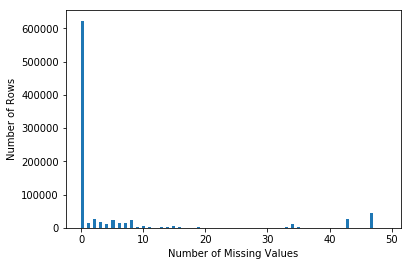

In [18]:
# How much data is missing in each row of the dataset?
missing_per_row =azdias.isnull().sum(axis=1)
plt.hist(missing_per_row, bins=100)
plt.ylabel('Number of Rows')
plt.xlabel('Number of Missing Values')
plt.show()

In [19]:
low_threshold = azdias[azdias.isnull().sum(axis=1) <= 3]
high_threshold = azdias[azdias.isnull().sum(axis=1) > 3]

In [20]:
no_missing_columns = missing_percent[missing_percent==0].index.tolist()
compare_columns = no_missing_columns[:6]
print(compare_columns)

['SEMIO_KULT', 'SEMIO_KAEM', 'SEMIO_DOM', 'SEMIO_KRIT', 'SEMIO_RAT', 'SEMIO_REL']


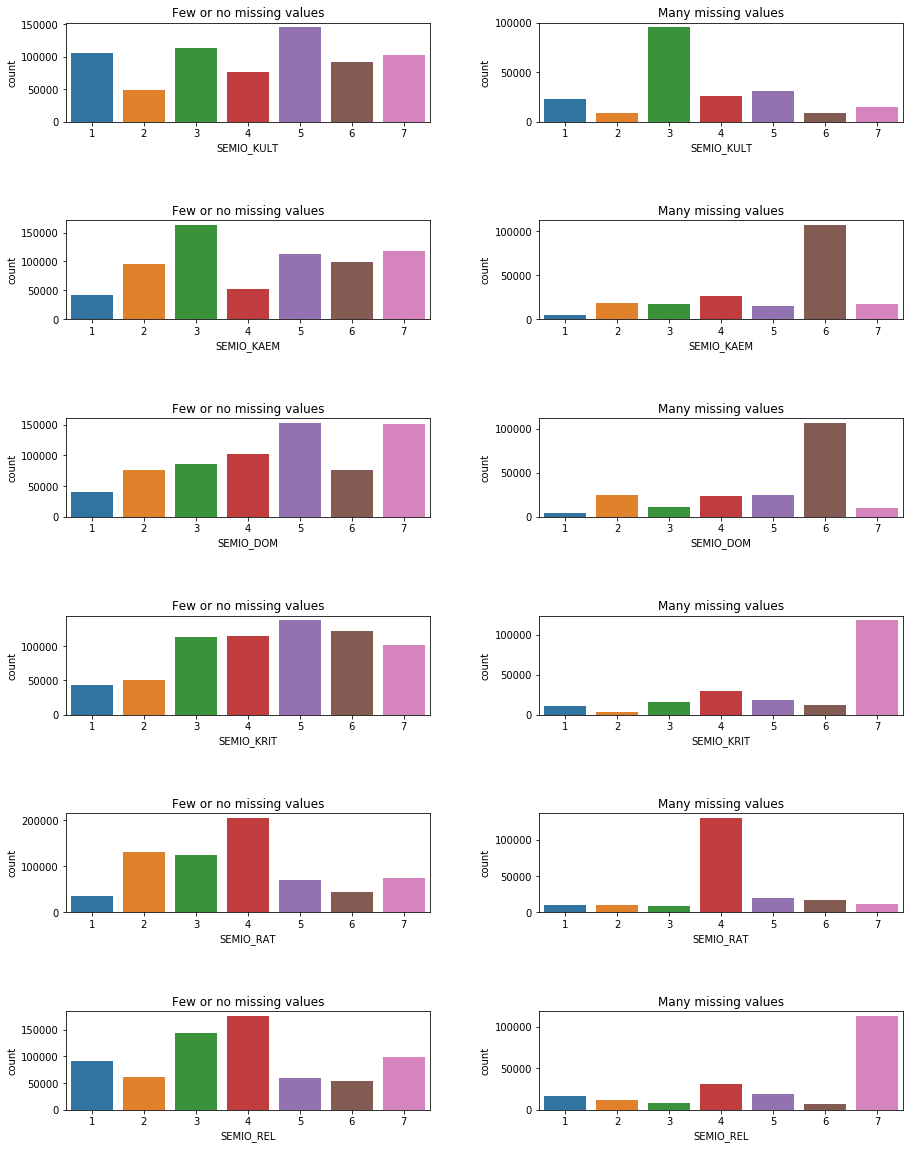

In [21]:
figure, axs = plt.subplots(nrows=len(compare_columns), ncols=2, figsize = (15,20))
figure.subplots_adjust(hspace = 1, wspace=.3)
for i in range(len(compare_columns)):
    sns.countplot(low_threshold[compare_columns[i]], ax=axs[i][0])
    axs[i][0].set_title('Few or no missing values')
    sns.countplot(high_threshold[compare_columns[i]], ax=axs[i][1])
    axs[i][1].set_title('Many missing values')

#### Discussion 1.1.3: Assess Missing Data in Each Row

(Double-click this cell and replace this text with your own text, reporting your observations regarding missing data in rows. Are the data with lots of missing values are qualitatively different from data with few or no missing values?)

After running the analysis I observed that the data with many missing values was very different from the data with few or missing values. The data set containing on few or missing values should be used to continue building the model, otherwise inconsistencies could occur in predictions.

### Step 1.2: Select and Re-Encode Features

Checking for missing data isn't the only way in which you can prepare a dataset for analysis. Since the unsupervised learning techniques to be used will only work on data that is encoded numerically, you need to make a few encoding changes or additional assumptions to be able to make progress. In addition, while almost all of the values in the dataset are encoded using numbers, not all of them represent numeric values. Check the third column of the feature summary (`feat_info`) for a summary of types of measurement.
- For numeric and interval data, these features can be kept without changes.
- Most of the variables in the dataset are ordinal in nature. While ordinal values may technically be non-linear in spacing, make the simplifying assumption that the ordinal variables can be treated as being interval in nature (that is, kept without any changes).
- Special handling may be necessary for the remaining two variable types: categorical, and 'mixed'.

In the first two parts of this sub-step, you will perform an investigation of the categorical and mixed-type features and make a decision on each of them, whether you will keep, drop, or re-encode each. Then, in the last part, you will create a new data frame with only the selected and engineered columns.

Data wrangling is often the trickiest part of the data analysis process, and there's a lot of it to be done here. But stick with it: once you're done with this step, you'll be ready to get to the machine learning parts of the project!

In [22]:
# How many features are there of each data type?
features = low_threshold.keys().tolist()
features = feat_info[feat_info['attribute'].isin(features)]
features['type'].value_counts()

ordinal        49
categorical    18
mixed           6
numeric         6
Name: type, dtype: int64

#### Step 1.2.1: Re-Encode Categorical Features

For categorical data, you would ordinarily need to encode the levels as dummy variables. Depending on the number of categories, perform one of the following:
- For binary (two-level) categoricals that take numeric values, you can keep them without needing to do anything.
- There is one binary variable that takes on non-numeric values. For this one, you need to re-encode the values as numbers or create a dummy variable.
- For multi-level categoricals (three or more values), you can choose to encode the values using multiple dummy variables (e.g. via [OneHotEncoder](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html)), or (to keep things straightforward) just drop them from the analysis. As always, document your choices in the Discussion section.

In [23]:
# Assess categorical variables: which are binary, which are multi-level, and
# which one needs to be re-encoded?
categorical_features = features[features['type'] == 'categorical']['attribute']

display(features.head())
display(categorical_features.head())


,attribute,information_level,type,missing_or_unknown
1,ALTERSKATEGORIE_GROB,person,ordinal,"[-1,0,9]"
2,ANREDE_KZ,person,categorical,"[-1,0]"
3,CJT_GESAMTTYP,person,categorical,[0]
4,FINANZ_MINIMALIST,person,ordinal,[-1]
5,FINANZ_SPARER,person,ordinal,[-1]


2            ANREDE_KZ
3        CJT_GESAMTTYP
10           FINANZTYP
12     GFK_URLAUBERTYP
13    GREEN_AVANTGARDE
Name: attribute, dtype: object

In [24]:
categorical_features = [categorical_features for categorical_features in categorical_features if categorical_features in azdias.columns] 
categorical_features

['ANREDE_KZ',
 'CJT_GESAMTTYP',
 'FINANZTYP',
 'GFK_URLAUBERTYP',
 'GREEN_AVANTGARDE',
 'LP_FAMILIE_FEIN',
 'LP_FAMILIE_GROB',
 'LP_STATUS_FEIN',
 'LP_STATUS_GROB',
 'NATIONALITAET_KZ',
 'SHOPPER_TYP',
 'SOHO_KZ',
 'VERS_TYP',
 'ZABEOTYP',
 'GEBAEUDETYP',
 'OST_WEST_KZ',
 'CAMEO_DEUG_2015',
 'CAMEO_DEU_2015']

In [25]:
# Re-encode categorical variable(s) to be kept in the analysis.

column_binary = []
column_multi = []
for column in categorical_features:
    if azdias[column].nunique() > 2:
        column_multi.append(column)
    else:
        column_binary.append(column)

In [26]:
print(column_binary)
print(column_multi)


['ANREDE_KZ', 'GREEN_AVANTGARDE', 'SOHO_KZ', 'VERS_TYP', 'OST_WEST_KZ']
['CJT_GESAMTTYP', 'FINANZTYP', 'GFK_URLAUBERTYP', 'LP_FAMILIE_FEIN', 'LP_FAMILIE_GROB', 'LP_STATUS_FEIN', 'LP_STATUS_GROB', 'NATIONALITAET_KZ', 'SHOPPER_TYP', 'ZABEOTYP', 'GEBAEUDETYP', 'CAMEO_DEUG_2015', 'CAMEO_DEU_2015']


In [27]:
for feature in column_binary:
    print('Unique values for {} are {}'.format(feature, low_threshold[feature].unique()))

Unique values for ANREDE_KZ are [2 1]
Unique values for GREEN_AVANTGARDE are [0 1]
Unique values for SOHO_KZ are [ 1.  0.]
Unique values for VERS_TYP are [ 2.  1.]
Unique values for OST_WEST_KZ are ['W' 'O']


In [28]:
#enconding categorical values for OST_WEST_KZ
alter_values = {'W': 0, 'O': 1}
low_threshold = low_threshold.replace({'OST_WEST_KZ':alter_values})


In [29]:
# Drop multi-level features
for feature in column_multi:
    low_threshold=low_threshold.drop(feature, axis=1)

#### Discussion 1.2.1: Re-Encode Categorical Features

(Double-click this cell and replace this text with your own text, reporting your findings and decisions regarding categorical features. Which ones did you keep, which did you drop, and what engineering steps did you perform?)

I dropped the multi-level categorical and kept all of the numerical, ordinal and mixed types. For one of the binary categorical features (as described in Data_Dictionary.md) I replaced the values of OST_WEST_KZ from W,O, to 0,1. 

#### Step 1.2.2: Engineer Mixed-Type Features

There are a handful of features that are marked as "mixed" in the feature summary that require special treatment in order to be included in the analysis. There are two in particular that deserve attention; the handling of the rest are up to your own choices:
- "PRAEGENDE_JUGENDJAHRE" combines information on three dimensions: generation by decade, movement (mainstream vs. avantgarde), and nation (east vs. west). While there aren't enough levels to disentangle east from west, you should create two new variables to capture the other two dimensions: an interval-type variable for decade, and a binary variable for movement.
- "CAMEO_INTL_2015" combines information on two axes: wealth and life stage. Break up the two-digit codes by their 'tens'-place and 'ones'-place digits into two new ordinal variables (which, for the purposes of this project, is equivalent to just treating them as their raw numeric values).
- If you decide to keep or engineer new features around the other mixed-type features, make sure you note your steps in the Discussion section.

Be sure to check `Data_Dictionary.md` for the details needed to finish these tasks.

In [30]:
mixed_features = features[features['type'] == 'mixed']['attribute']
display(mixed_features.head())

15      LP_LEBENSPHASE_FEIN
16      LP_LEBENSPHASE_GROB
22    PRAEGENDE_JUGENDJAHRE
56                 WOHNLAGE
59          CAMEO_INTL_2015
Name: attribute, dtype: object

In [31]:
# Investigate "PRAEGENDE_JUGENDJAHRE" and engineer two new variables.

decade = {1:1, 2:1, 3:2, 4:2, 5:3, 6:3, 7:3, 8:4, 9:4, 10:5, 11:5, 12:5, 13:5, 14:6, 15:6}
movement = {1:0, 2:1, 3:0, 4:1, 5:0, 6:1, 7:1, 8:0, 9:1, 10:0, 11:1, 12:0, 13:1, 14:0, 15:1}

#creating the new variables based on findings in Data_Dictionary.md
low_threshold['DECADE'] = low_threshold['PRAEGENDE_JUGENDJAHRE']
low_threshold['DECADE'].replace(decade, inplace = True)

low_threshold['MOVEMENT'] = low_threshold['PRAEGENDE_JUGENDJAHRE']
low_threshold['MOVEMENT'].replace(movement, inplace = True)

In [32]:
# Investigate "CAMEO_INTL_2015" and engineer two new variables.

household_wealth = {'11':1, '12':1, '13':1, '14':1, '15':1, '21':2, '22':2, '23':2, '24':2, '25':2, 
'31':3, '32':3, '33':3, '34':3, '35':3, '41':4, '42':4, '43':4, '44':4, '45':4, '51':5, '52':5, 
'53':5, '54':5, '55':5,}

life_stage={'11':1, '12':1, '13':1, '14':1, '15':1, '21':2, '22':2, '23':2, '24':2, '25':2, 
'31':3, '32':3, '33':3, '34':3, '35':3, '41':4, '42':4, '43':4, '44':4, '45':4, '51':5, '52':5, 
'53':5, '54':5, '55':5,}

low_threshold['HOUSEHOLD_WEALTH'] = low_threshold['CAMEO_INTL_2015']
low_threshold['HOUSEHOLD_WEALTH'].replace(household_wealth, inplace = True)

low_threshold['LIFE_STAGE'] = low_threshold['CAMEO_INTL_2015']
low_threshold['LIFE_STAGE'].replace(life_stage, inplace = True)

In [33]:
for feature in mixed_features:
        low_threshold.drop(feature, axis=1, inplace=True)

In [34]:
low_threshold.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,PLZ8_ANTG4,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,DECADE,MOVEMENT,HOUSEHOLD_WEALTH,LIFE_STAGE
1,1.0,2,1,5,2,5,4,5,0,3.0,...,1.0,5.0,4.0,3.0,5.0,4.0,6.0,0.0,5.0,5.0
2,3.0,2,1,4,1,2,3,5,1,3.0,...,0.0,4.0,4.0,3.0,5.0,2.0,6.0,1.0,2.0,2.0
4,3.0,1,4,3,4,1,3,2,0,3.0,...,1.0,3.0,3.0,4.0,6.0,5.0,4.0,0.0,4.0,4.0
5,1.0,2,3,1,5,2,2,5,0,3.0,...,1.0,5.0,5.0,2.0,3.0,3.0,2.0,0.0,5.0,5.0
6,2.0,2,1,5,1,5,4,3,0,2.0,...,0.0,5.0,5.0,4.0,6.0,3.0,5.0,0.0,2.0,2.0


#### Discussion 1.2.2: Engineer Mixed-Type Features

I investigated all of the mixed-type features in the provided Data_Dictionary.md, and out of the 5, I decided to keep only the two that were indicated for the task.

- LP_LEBENSPHASE_FEIN - Life stage, fine scale
- LP_LEBENSPHASE_GROB - Life stage, rough scale
- PRAEGENDE_JUGENDJAHRE - Dominating movement of person's youth (avantgarde vs. mainstream; east vs. west) by Decade
- WOHNLAGE - Neighborhood quality (or rural flag)
- CAMEO_INTL_2015 - Wealth / Life Stage Typology

Of the five mixed-type features, PRAEGENDE_JUGENDJAHRE and CAMEO_INTL_2015 had the two columns added and were encoded. The other three features did not appear relevant enough to include so they were excluded and dropped.

#### Step 1.2.3: Complete Feature Selection

In order to finish this step up, you need to make sure that your data frame now only has the columns that you want to keep. To summarize, the dataframe should consist of the following:
- All numeric, interval, and ordinal type columns from the original dataset.
- Binary categorical features (all numerically-encoded).
- Engineered features from other multi-level categorical features and mixed features.

Make sure that for any new columns that you have engineered, that you've excluded the original columns from the final dataset. Otherwise, their values will interfere with the analysis later on the project. For example, you should not keep "PRAEGENDE_JUGENDJAHRE", since its values won't be useful for the algorithm: only the values derived from it in the engineered features you created should be retained. As a reminder, your data should only be from **the subset with few or no missing values**.

In [35]:
# If there are other re-engineering tasks you need to perform, make sure you
# take care of them here. (Dealing with missing data will come in step 2.1.)



In [36]:
# Do whatever you need to in order to ensure that the dataframe only contains
# the columns that should be passed to the algorithm functions.
#checking that I already removed the needed features
features = low_threshold.keys().tolist()
features = feat_info[feat_info['attribute'].isin(features)] #extracting the needed features only
features['type'].value_counts()

ordinal        49
numeric         6
categorical     5
Name: type, dtype: int64

### Step 1.3: Create a Cleaning Function

Even though you've finished cleaning up the general population demographics data, it's important to look ahead to the future and realize that you'll need to perform the same cleaning steps on the customer demographics data. In this substep, complete the function below to execute the main feature selection, encoding, and re-engineering steps you performed above. Then, when it comes to looking at the customer data in Step 3, you can just run this function on that DataFrame to get the trimmed dataset in a single step.

In [37]:
def clean_data(df):
    """
    Perform feature trimming, re-encoding, and engineering for demographics
    data
    
    INPUT: Demographics DataFrame
    OUTPUT: Trimmed and cleaned demographics DataFrame
    """
    
    # Put in code here to execute all main cleaning steps:
    # convert missing value codes into NaNs, ...
    for i in range(len(feat_info)):
        #extracting and splitting
        missing_values = re.sub('[\[|\]]', '',feat_info.iloc[i]['missing_or_unknown']).split(',')
        # returing int values
        if missing_values != ['']:
            missing_values = [np.int64(data) if (data!='X' and data!='XX') else data for data in missing_values]
            df = df.replace({feat_info.iloc[i]['attribute']: missing_values}, np.nan)
            
    # remove selected columns and rows.
 
    df = df.drop(columns = outlier_missing_values.index, axis='columns')
    
    #removing rows
    df = df[df.isnull().sum(axis=1) <= 3]
    
    
    # select, re-encode, and engineer column values.
    df.replace({'OST_WEST_KZ':{'W':0, 'O': 1}}, inplace = True)
    
    for feature in column_multi:
        df= df.drop(feature, axis=1)
        
   #Engineer new columns     
    df['DECADE'] = df['PRAEGENDE_JUGENDJAHRE']
    df['DECADE'].replace(decade, inplace = True)
    
    df['MOVEMENT'] = df['PRAEGENDE_JUGENDJAHRE']
    df['MOVEMENT'].replace(movement, inplace = True)
    
    df['HOUSEHOLD_WEALTH'] = df['CAMEO_INTL_2015']
    df['HOUSEHOLD_WEALTH'].replace(household_wealth, inplace = True)
    
    df['LIFE_STAGE'] = df['CAMEO_INTL_2015']
    df['LIFE_STAGE'].replace(life_stage, inplace = True)
    
    df = df.drop(mixed_features, axis = 1)
    
    # Return the cleaned dataframe.
    return (df)
    

## Step 2: Feature Transformation

### Step 2.1: Apply Feature Scaling

Before we apply dimensionality reduction techniques to the data, we need to perform feature scaling so that the principal component vectors are not influenced by the natural differences in scale for features. Starting from this part of the project, you'll want to keep an eye on the [API reference page for sklearn](http://scikit-learn.org/stable/modules/classes.html) to help you navigate to all of the classes and functions that you'll need. In this substep, you'll need to check the following:

- sklearn requires that data not have missing values in order for its estimators to work properly. So, before applying the scaler to your data, make sure that you've cleaned the DataFrame of the remaining missing values. This can be as simple as just removing all data points with missing data, or applying an [Imputer](https://scikit-learn.org/0.16/modules/generated/sklearn.preprocessing.Imputer.html) to replace all missing values. You might also try a more complicated procedure where you temporarily remove missing values in order to compute the scaling parameters before re-introducing those missing values and applying imputation. Think about how much missing data you have and what possible effects each approach might have on your analysis, and justify your decision in the discussion section below.
- For the actual scaling function, a [StandardScaler](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) instance is suggested, scaling each feature to mean 0 and standard deviation 1.
- For these classes, you can make use of the `.fit_transform()` method to both fit a procedure to the data as well as apply the transformation to the data at the same time. Don't forget to keep the fit sklearn objects handy, since you'll be applying them to the customer demographics data towards the end of the project.

In [38]:
# If you've not yet cleaned the dataset of all NaN values, then investigate and
# do that now.

fill_nan = Imputer(strategy='most_frequent')
low_threshold_imputed = pd.DataFrame(fill_nan.fit_transform(low_threshold))

In [39]:
low_threshold_imputed.columns = low_threshold.columns
low_threshold_imputed.index = low_threshold.index

In [40]:
# Apply feature scaling to the general population demographics data.
scaler = StandardScaler() 
low_threshold_scaled = scaler.fit_transform(low_threshold_imputed)


In [41]:
low_threshold_scaled = pd.DataFrame(low_threshold_scaled, columns=list(low_threshold_imputed))

In [42]:
low_threshold_scaled.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,PLZ8_ANTG4,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,DECADE,MOVEMENT,HOUSEHOLD_WEALTH,LIFE_STAGE
0,-1.747634,0.975423,-1.523655,1.588878,-1.050212,1.513292,1.048651,1.341142,-0.542999,1.038860,...,0.409122,1.432172,0.564740,-0.187976,-0.133875,0.678924,1.144730,-0.542999,1.169744,1.169744
1,0.193497,0.975423,-1.523655,0.908468,-1.771419,-0.548762,0.320698,1.341142,1.841624,1.038860,...,-0.963869,0.402503,0.564740,-0.187976,-0.133875,-0.799090,1.144730,1.841624,-0.873113,-0.873113
2,0.193497,-1.025197,0.677626,0.228057,0.392200,-1.236113,0.320698,-0.834925,-0.542999,1.038860,...,0.409122,-0.627167,-0.334972,0.816965,0.301888,1.417930,-0.232759,-0.542999,0.488792,0.488792
3,-1.747634,0.975423,-0.056134,-1.132765,1.113406,-0.548762,-0.407255,1.341142,-0.542999,1.038860,...,0.409122,1.432172,1.464451,-1.192917,-1.005401,-0.060083,-1.610248,-0.542999,1.169744,1.169744
4,-0.777068,0.975423,-1.523655,1.588878,-1.771419,1.513292,1.048651,-0.109569,-0.542999,-0.285764,...,-0.963869,1.432172,1.464451,0.816965,0.301888,-0.060083,0.455986,-0.542999,-0.873113,-0.873113


### Discussion 2.1: Apply Feature Scaling

I applied the sklearn imputer to replace the missing values in a column with the most frequent value. I then applied feature scaling using Standard Scalar.

### Step 2.2: Perform Dimensionality Reduction

On your scaled data, you are now ready to apply dimensionality reduction techniques.

- Use sklearn's [PCA](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) class to apply principal component analysis on the data, thus finding the vectors of maximal variance in the data. To start, you should not set any parameters (so all components are computed) or set a number of components that is at least half the number of features (so there's enough features to see the general trend in variability).
- Check out the ratio of variance explained by each principal component as well as the cumulative variance explained. Try plotting the cumulative or sequential values using matplotlib's [`plot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.plot.html) function. Based on what you find, select a value for the number of transformed features you'll retain for the clustering part of the project.
- Once you've made a choice for the number of components to keep, make sure you re-fit a PCA instance to perform the decided-on transformation.

In [43]:
# Apply PCA to the data.

pca = PCA()
pca.fit(low_threshold_scaled)

PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

In [44]:
# Investigate the variance accounted for by each principal component.
print(pca.explained_variance_ratio_)


[  1.76166006e-01   1.39052092e-01   9.56878151e-02   5.43300537e-02
   3.79169293e-02   3.17241593e-02   2.81843864e-02   2.47363630e-02
   2.34377822e-02   2.13782965e-02   2.05437547e-02   1.92033379e-02
   1.80199738e-02   1.74716636e-02   1.61746883e-02   1.56206162e-02
   1.47511268e-02   1.42969386e-02   1.30607793e-02   1.28611039e-02
   1.21663216e-02   1.20911544e-02   1.12614389e-02   1.08928459e-02
   1.04899018e-02   8.52569047e-03   7.84701323e-03   7.44912157e-03
   7.31805963e-03   7.19349707e-03   6.57879692e-03   6.51522377e-03
   6.27270879e-03   6.18053057e-03   5.91620523e-03   5.53125056e-03
   4.87396842e-03   4.68374215e-03   4.44448465e-03   4.24768254e-03
   3.93421630e-03   3.84730716e-03   3.69818660e-03   3.43992237e-03
   3.25030758e-03   3.21725025e-03   3.14423387e-03   2.95986044e-03
   2.90729753e-03   2.68400206e-03   2.59378255e-03   2.48257329e-03
   2.32671077e-03   2.20082101e-03   2.16173683e-03   1.93842173e-03
   1.74553541e-03   1.65872537e-03

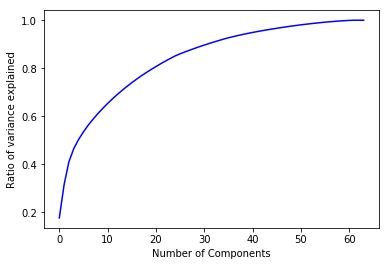

In [45]:
plt.plot(range(pca.explained_variance_ratio_.shape[0]), np.cumsum(pca.explained_variance_ratio_), color = 'blue')
plt.xlabel("Number of Components")
plt.ylabel("Ratio of variance explained")
plt.show()

In [46]:
# Re-apply PCA to the data while selecting for number of components to retain.

pca_30 = PCA(n_components=30)
low_threshold_pca = pca_30.fit_transform(low_threshold_scaled)

### Discussion 2.2: Perform Dimensionality Reduction

I decided to re-apply PCA with the number of components equal to 30, from the results of the plot I accessed that nearly 90% of the data can be explained with this number of components.

### Step 2.3: Interpret Principal Components

Now that we have our transformed principal components, it's a nice idea to check out the weight of each variable on the first few components to see if they can be interpreted in some fashion.

As a reminder, each principal component is a unit vector that points in the direction of highest variance (after accounting for the variance captured by earlier principal components). The further a weight is from zero, the more the principal component is in the direction of the corresponding feature. If two features have large weights of the same sign (both positive or both negative), then increases in one tend expect to be associated with increases in the other. To contrast, features with different signs can be expected to show a negative correlation: increases in one variable should result in a decrease in the other.

- To investigate the features, you should map each weight to their corresponding feature name, then sort the features according to weight. The most interesting features for each principal component, then, will be those at the beginning and end of the sorted list. Use the data dictionary document to help you understand these most prominent features, their relationships, and what a positive or negative value on the principal component might indicate.
- You should investigate and interpret feature associations from the first three principal components in this substep. To help facilitate this, you should write a function that you can call at any time to print the sorted list of feature weights, for the *i*-th principal component. This might come in handy in the next step of the project, when you interpret the tendencies of the discovered clusters.

In [47]:
# Map weights for the first principal component to corresponding feature names
# and then print the linked values, sorted by weight.
# HINT: Try defining a function here or in a new cell that you can reuse in the
# other cells.

def weight_maps(pca, i):
    df = pd.DataFrame(pca.components_, columns=list(low_threshold_scaled.columns))
    weights = df.iloc[i].sort_values(ascending=False)
    return weights

weight_maps(pca,0)

PLZ8_ANTG3               0.223061
PLZ8_ANTG4               0.215662
LIFE_STAGE               0.211288
HOUSEHOLD_WEALTH         0.211288
HH_EINKOMMEN_SCORE       0.203404
ORTSGR_KLS9              0.191339
EWDICHTE                 0.188844
FINANZ_HAUSBAUER         0.158762
KBA05_ANTG4              0.152185
PLZ8_ANTG2               0.150973
ARBEIT                   0.142900
FINANZ_SPARER            0.137501
KBA05_ANTG3              0.136853
ANZ_HAUSHALTE_AKTIV      0.136358
RELAT_AB                 0.132252
SEMIO_PFLICHT            0.105781
SEMIO_REL                0.102545
DECADE                   0.098352
SEMIO_TRADV              0.089313
SEMIO_RAT                0.088445
SEMIO_MAT                0.079084
SEMIO_FAM                0.075124
SEMIO_KULT               0.069123
FINANZ_UNAUFFAELLIGER    0.068746
REGIOTYP                 0.062478
FINANZ_ANLEGER           0.060288
OST_WEST_KZ              0.058723
SEMIO_SOZ                0.043510
KKK                      0.042420
PLZ8_HHZ      

In [48]:
# Map weights for the second principal component to corresponding feature names
# and then print the linked values, sorted by weight.

weight_maps(pca , 1)

ALTERSKATEGORIE_GROB     0.262777
SEMIO_ERL                0.234464
FINANZ_VORSORGER         0.230872
SEMIO_LUST               0.183920
RETOURTYP_BK_S           0.164404
SEMIO_KRIT               0.119255
W_KEIT_KIND_HH           0.112761
FINANZ_HAUSBAUER         0.111990
SEMIO_KAEM               0.108938
ANREDE_KZ                0.088962
PLZ8_ANTG3               0.087565
EWDICHTE                 0.083950
PLZ8_ANTG4               0.083416
ORTSGR_KLS9              0.082738
LIFE_STAGE               0.072222
HOUSEHOLD_WEALTH         0.072222
FINANZ_MINIMALIST        0.069931
KBA05_ANTG4              0.065515
SEMIO_DOM                0.065301
ARBEIT                   0.062491
RELAT_AB                 0.060072
WOHNDAUER_2008           0.060040
PLZ8_ANTG2               0.059703
ANZ_HAUSHALTE_AKTIV      0.057419
HH_EINKOMMEN_SCORE       0.049226
KBA05_ANTG3              0.042976
VERS_TYP                 0.029417
ANZ_HH_TITEL             0.028819
OST_WEST_KZ              0.025842
REGIOTYP      

In [49]:
# Map weights for the third principal component to corresponding feature names
# and then print the linked values, sorted by weight.
weight_maps(pca , 2)


SEMIO_VERT               0.348423
SEMIO_SOZ                0.263329
SEMIO_FAM                0.250813
SEMIO_KULT               0.232635
FINANZ_MINIMALIST        0.159512
RETOURTYP_BK_S           0.115922
FINANZ_VORSORGER         0.100231
W_KEIT_KIND_HH           0.089737
ALTERSKATEGORIE_GROB     0.084189
SEMIO_REL                0.079226
SEMIO_LUST               0.074835
SEMIO_MAT                0.051886
GREEN_AVANTGARDE         0.049906
MOVEMENT                 0.049906
EWDICHTE                 0.043537
ORTSGR_KLS9              0.043440
PLZ8_ANTG4               0.041845
PLZ8_ANTG3               0.041351
WOHNDAUER_2008           0.035879
ARBEIT                   0.030063
RELAT_AB                 0.028847
PLZ8_ANTG2               0.028064
KBA05_ANTG4              0.025847
LIFE_STAGE               0.024504
HOUSEHOLD_WEALTH         0.024504
ANZ_HAUSHALTE_AKTIV      0.024051
VERS_TYP                 0.021310
ANZ_HH_TITEL             0.013453
OST_WEST_KZ              0.011152
ANZ_TITEL     

### Discussion 2.3: Interpret Principal Components

(Double-click this cell and replace this text with your own text, reporting your observations from detailed investigation of the first few principal components generated. Can we interpret positive and negative values from them in a meaningful way?)

**First Component**

Positive:
- PLZ8_ANTG3 (Number of 6-10 family houses in the PLZ8 region), 
- PLZ8_ANTG4 (Number of 10+ family houses in the PLZ8 region) 

Negative:
- KBA05_ANTG1 (Number of 1-2 family houses in the microcell), 
- MOBI_REGIO (Movement patterns)

**Second Component** 

Positive:
- ALTERSKATEGORIE_GROB (Estimated age based on given name analysis )
- SEMIO_ERL (event-oriented personality topology)

Negative:
- DECADE(Time Period/Dominating period of life)
- SEMIO_REL(Personality Topology: Religious)


**Third Component:**

Positive:
- SEMIO_VERT (Personality Topology: dreamful)
- SEMIO_SOZ (Personality Topology:socially-minded) 

Negative:

- SEMIO_KAEM (Personality Topology: combative attitude)
- ANREDE_KZ(Gender)

## Step 3: Clustering

### Step 3.1: Apply Clustering to General Population

You've assessed and cleaned the demographics data, then scaled and transformed them. Now, it's time to see how the data clusters in the principal components space. In this substep, you will apply k-means clustering to the dataset and use the average within-cluster distances from each point to their assigned cluster's centroid to decide on a number of clusters to keep.

- Use sklearn's [KMeans](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html#sklearn.cluster.KMeans) class to perform k-means clustering on the PCA-transformed data.
- Then, compute the average difference from each point to its assigned cluster's center. **Hint**: The KMeans object's `.score()` method might be useful here, but note that in sklearn, scores tend to be defined so that larger is better. Try applying it to a small, toy dataset, or use an internet search to help your understanding.
- Perform the above two steps for a number of different cluster counts. You can then see how the average distance decreases with an increasing number of clusters. However, each additional cluster provides a smaller net benefit. Use this fact to select a final number of clusters in which to group the data. **Warning**: because of the large size of the dataset, it can take a long time for the algorithm to resolve. The more clusters to fit, the longer the algorithm will take. You should test for cluster counts through at least 10 clusters to get the full picture, but you shouldn't need to test for a number of clusters above about 30.
- Once you've selected a final number of clusters to use, re-fit a KMeans instance to perform the clustering operation. Make sure that you also obtain the cluster assignments for the general demographics data, since you'll be using them in the final Step 3.3.

In [50]:
# Over a number of different cluster counts...
clusters = [2, 4, 6, 8, 10, 12, 14, 16, 18, 20, 21, 22, 23, 24, 25]
scores = []
for cluster in clusters:
    kmeans = KMeans(n_clusters = cluster)
    model = kmeans.fit(low_threshold_pca)
    score = np.abs(model.score(low_threshold_pca))
    scores.append(score)        

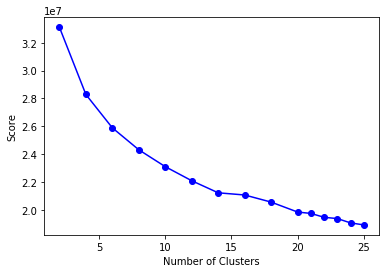

In [51]:
# Investigate the change in within-cluster distance across number of clusters.
# HINT: Use matplotlib's plot function to visualize this relationship.
plt.plot(clusters, scores, marker = 'o', color = 'b')
plt.xlabel('Number of Clusters')
plt.ylabel('Score')
plt.show()


In [52]:
# Re-fit the k-means model with the selected number of clusters and obtain
# cluster predictions for the general population demographics data.
kmeans = KMeans(n_clusters = 18)
model = kmeans.fit(low_threshold_pca)
low_threshold_pred = model.predict(low_threshold_pca)


### Discussion 3.1: Apply Clustering to General Population

I first tested with only 12 clusters, but found that it did not appear enough to make a conclusion. I then ran with 20, and then with 25. Running it with more clusters provided a better elbow to read, so I then selected 18 clusters for my model.

### Step 3.2: Apply All Steps to the Customer Data

Now that you have clusters and cluster centers for the general population, it's time to see how the customer data maps on to those clusters. Take care to not confuse this for re-fitting all of the models to the customer data. Instead, you're going to use the fits from the general population to clean, transform, and cluster the customer data. In the last step of the project, you will interpret how the general population fits apply to the customer data.

- Don't forget when loading in the customers data, that it is semicolon (`;`) delimited.
- Apply the same feature wrangling, selection, and engineering steps to the customer demographics using the `clean_data()` function you created earlier. (You can assume that the customer demographics data has similar meaning behind missing data patterns as the general demographics data.)
- Use the sklearn objects from the general demographics data, and apply their transformations to the customers data. That is, you should not be using a `.fit()` or `.fit_transform()` method to re-fit the old objects, nor should you be creating new sklearn objects! Carry the data through the feature scaling, PCA, and clustering steps, obtaining cluster assignments for all of the data in the customer demographics data.

In [53]:
# Load in the customer demographics data.
customers = pd.read_csv('Udacity_CUSTOMERS_Subset.csv', delimiter =';')
customers.head()

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,2,4,1,5.0,5,1,5,1,2,2,...,3.0,3.0,1.0,0.0,1.0,5.0,5.0,1.0,2.0,1.0
1,-1,4,1,NaN,5,1,5,1,3,2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,-1,4,2,2.0,5,1,5,1,4,4,...,2.0,3.0,3.0,1.0,3.0,3.0,2.0,3.0,5.0,3.0
3,1,4,1,2.0,5,1,5,2,1,2,...,3.0,2.0,1.0,0.0,1.0,3.0,4.0,1.0,3.0,1.0
4,-1,3,1,6.0,3,1,4,4,5,2,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,3.0,5.0,1.0


In [54]:
# Apply preprocessing, feature transformation, and clustering from the general
# demographics onto the customer data, obtaining cluster predictions for the
# customer demographics data.

customers_clean = clean_data(customers)
customers_clean

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,PLZ8_ANTG4,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,DECADE,MOVEMENT,HOUSEHOLD_WEALTH,LIFE_STAGE
0,4.0,1,5,1,5,1,2,2,1,1.0,...,0.0,5.0,5.0,1.0,2.0,1.0,2.0,1.0,1.0,1.0
2,4.0,2,5,1,5,1,4,4,1,2.0,...,1.0,3.0,2.0,3.0,5.0,3.0,2.0,1.0,3.0,3.0
4,3.0,1,3,1,4,4,5,2,0,3.0,...,1.0,3.0,3.0,3.0,5.0,1.0,4.0,0.0,4.0,4.0
5,3.0,1,5,1,5,1,2,3,1,3.0,...,1.0,5.0,5.0,3.0,7.0,5.0,2.0,1.0,3.0,3.0
6,4.0,1,5,1,5,1,1,2,1,2.0,...,0.0,5.0,5.0,2.0,3.0,2.0,2.0,1.0,2.0,2.0
7,4.0,1,5,1,5,1,2,2,1,1.0,...,1.0,3.0,3.0,3.0,4.0,3.0,2.0,1.0,1.0,1.0
8,4.0,2,2,2,5,1,1,5,0,2.0,...,1.0,5.0,4.0,3.0,8.0,3.0,1.0,0.0,5.0,5.0
9,3.0,1,5,2,4,1,3,1,1,3.0,...,0.0,5.0,5.0,3.0,6.0,4.0,4.0,1.0,1.0,1.0
11,4.0,1,5,1,5,1,3,2,1,1.0,...,0.0,3.0,3.0,2.0,5.0,1.0,2.0,1.0,1.0,1.0
12,4.0,1,5,2,4,3,2,1,0,2.0,...,0.0,4.0,5.0,1.0,1.0,1.0,4.0,0.0,2.0,2.0


In [55]:
#replace nans
fill_nan_customers = Imputer(strategy='most_frequent')
customers_imputed = pd.DataFrame(fill_nan_customers.fit_transform(customers_clean))


In [56]:
customers_imputed.columns = customers_clean.columns
customers_imputed.index = customers_clean.index

In [57]:
#viewing the head to check the data
customers_imputed.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,PLZ8_ANTG4,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,DECADE,MOVEMENT,HOUSEHOLD_WEALTH,LIFE_STAGE
0,4.0,1.0,5.0,1.0,5.0,1.0,2.0,2.0,1.0,1.0,...,0.0,5.0,5.0,1.0,2.0,1.0,2.0,1.0,1.0,1.0
2,4.0,2.0,5.0,1.0,5.0,1.0,4.0,4.0,1.0,2.0,...,1.0,3.0,2.0,3.0,5.0,3.0,2.0,1.0,3.0,3.0
4,3.0,1.0,3.0,1.0,4.0,4.0,5.0,2.0,0.0,3.0,...,1.0,3.0,3.0,3.0,5.0,1.0,4.0,0.0,4.0,4.0
5,3.0,1.0,5.0,1.0,5.0,1.0,2.0,3.0,1.0,3.0,...,1.0,5.0,5.0,3.0,7.0,5.0,2.0,1.0,3.0,3.0
6,4.0,1.0,5.0,1.0,5.0,1.0,1.0,2.0,1.0,2.0,...,0.0,5.0,5.0,2.0,3.0,2.0,2.0,1.0,2.0,2.0


In [58]:
#apply scaling
customers_scaled = scaler.fit_transform(customers_imputed)
customers_scaled = pd.DataFrame(customers_scaled, columns=list(customers_imputed))
customers_pca = pca_30.fit_transform(customers_scaled)


In [59]:
customers = scaler.transform(customers_imputed)
customers_pca = pca_30.transform(customers)
predections_customers = model.predict(customers_pca)

In [60]:
#Predict using Kmeans model
model = kmeans.fit(customers_pca)
customers_pred = model.predict(customers_pca)

### Step 3.3: Compare Customer Data to Demographics Data

At this point, you have clustered data based on demographics of the general population of Germany, and seen how the customer data for a mail-order sales company maps onto those demographic clusters. In this final substep, you will compare the two cluster distributions to see where the strongest customer base for the company is.

Consider the proportion of persons in each cluster for the general population, and the proportions for the customers. If we think the company's customer base to be universal, then the cluster assignment proportions should be fairly similar between the two. If there are only particular segments of the population that are interested in the company's products, then we should see a mismatch from one to the other. If there is a higher proportion of persons in a cluster for the customer data compared to the general population (e.g. 5% of persons are assigned to a cluster for the general population, but 15% of the customer data is closest to that cluster's centroid) then that suggests the people in that cluster to be a target audience for the company. On the other hand, the proportion of the data in a cluster being larger in the general population than the customer data (e.g. only 2% of customers closest to a population centroid that captures 6% of the data) suggests that group of persons to be outside of the target demographics.

Take a look at the following points in this step:

- Compute the proportion of data points in each cluster for the general population and the customer data. Visualizations will be useful here: both for the individual dataset proportions, but also to visualize the ratios in cluster representation between groups. Seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) or [`barplot()`](https://seaborn.pydata.org/generated/seaborn.barplot.html) function could be handy.
  - Recall the analysis you performed in step 1.1.3 of the project, where you separated out certain data points from the dataset if they had more than a specified threshold of missing values. If you found that this group was qualitatively different from the main bulk of the data, you should treat this as an additional data cluster in this analysis. Make sure that you account for the number of data points in this subset, for both the general population and customer datasets, when making your computations!
- Which cluster or clusters are overrepresented in the customer dataset compared to the general population? Select at least one such cluster and infer what kind of people might be represented by that cluster. Use the principal component interpretations from step 2.3 or look at additional components to help you make this inference. Alternatively, you can use the `.inverse_transform()` method of the PCA and StandardScaler objects to transform centroids back to the original data space and interpret the retrieved values directly.
- Perform a similar investigation for the underrepresented clusters. Which cluster or clusters are underrepresented in the customer dataset compared to the general population, and what kinds of people are typified by these clusters?

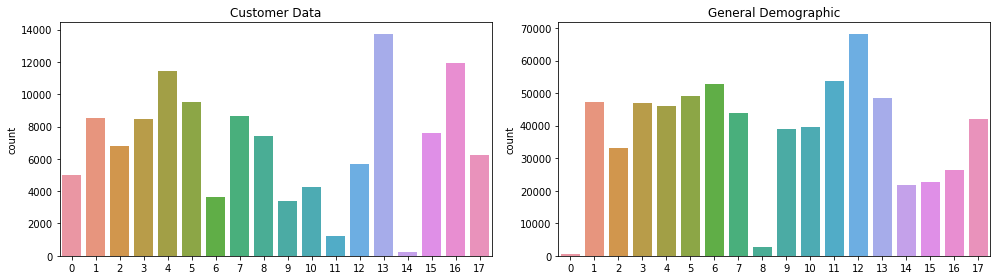

In [61]:
# Compare the proportion of data in each cluster for the customer data to the
# proportion of data in each cluster for the general population.
fig = plt.figure(figsize=(14,4))
ax1 = fig.add_subplot(121)
ax1.title.set_text('Customer Data')
sns.countplot(customers_pred)

ax2 = fig.add_subplot(122)
ax2.title.set_text('General Demographic')
sns.countplot(low_threshold_pred)
fig.tight_layout() 
plt.show()


In [65]:
# What kinds of people are part of a cluster that is overrepresented in the
# customer data compared to the general population?

type_13 = scaler.inverse_transform(pca_30.inverse_transform(model.cluster_centers_[13]))
overrepresented = pd.Series(data = type_13, index = customers_clean.columns)
display(overrepresented)

ALTERSKATEGORIE_GROB        3.957432
ANREDE_KZ                   0.976130
FINANZ_MINIMALIST           4.972060
FINANZ_SPARER               1.081513
FINANZ_VORSORGER            4.880304
FINANZ_ANLEGER              1.008697
FINANZ_UNAUFFAELLIGER       1.622431
FINANZ_HAUSBAUER            2.281623
GREEN_AVANTGARDE            0.934435
HEALTH_TYP                  1.030334
RETOURTYP_BK_S              4.235663
SEMIO_SOZ                   4.871902
SEMIO_FAM                   4.302218
SEMIO_REL                   3.764359
SEMIO_MAT                   5.322494
SEMIO_VERT                  6.678437
SEMIO_LUST                  6.824101
SEMIO_ERL                   3.222586
SEMIO_KULT                  4.652970
SEMIO_RAT                   1.867799
SEMIO_KRIT                  2.711943
SEMIO_DOM                   2.585597
SEMIO_KAEM                  1.351520
SEMIO_PFLICHT               2.390262
SEMIO_TRADV                 2.410252
SOHO_KZ                     0.000035
VERS_TYP                    1.041542
A

In [66]:
# What kinds of people are part of a cluster that is underrepresented in the
# customer data compared to the general population?

type_12 = scaler.inverse_transform(pca_30.inverse_transform(model.cluster_centers_[12]))
underrepresented = pd.Series(data = type_12, index = customers_clean.columns)
display(underrepresented)

ALTERSKATEGORIE_GROB        2.797423
ANREDE_KZ                   1.948497
FINANZ_MINIMALIST           3.782517
FINANZ_SPARER               2.660441
FINANZ_VORSORGER            3.299017
FINANZ_ANLEGER              3.407233
FINANZ_UNAUFFAELLIGER       2.701260
FINANZ_HAUSBAUER            1.871472
GREEN_AVANTGARDE            0.504425
HEALTH_TYP                  2.221960
RETOURTYP_BK_S              2.800018
SEMIO_SOZ                   2.972218
SEMIO_FAM                   2.615609
SEMIO_REL                   3.027526
SEMIO_MAT                   3.232361
SEMIO_VERT                  3.000469
SEMIO_LUST                  3.943693
SEMIO_ERL                   5.540536
SEMIO_KULT                  2.706594
SEMIO_RAT                   4.479417
SEMIO_KRIT                  5.532311
SEMIO_DOM                   5.862795
SEMIO_KAEM                  5.779221
SEMIO_PFLICHT               4.277163
SEMIO_TRADV                 3.662240
SOHO_KZ                     0.000082
VERS_TYP                    1.327318
A

In [67]:
#combining the data to get a comparison
pd.set_option('display.max_rows', None)
df_both = pd.concat([overrepresented, underrepresented], axis=1).reset_index()
df_both.columns = ['index', 'overrepresented', 'underrepresented']
df_both['difference'] = df_both['overrepresented'] - df_both['underrepresented']
df_both

,index,overrepresented,underrepresented,difference
0,ALTERSKATEGORIE_GROB,3.957432,2.797423,1.160009
1,ANREDE_KZ,0.976130,1.948497,-0.972366
2,FINANZ_MINIMALIST,4.972060,3.782517,1.189542
3,FINANZ_SPARER,1.081513,2.660441,-1.578928
4,FINANZ_VORSORGER,4.880304,3.299017,1.581287
5,FINANZ_ANLEGER,1.008697,3.407233,-2.398536
6,FINANZ_UNAUFFAELLIGER,1.622431,2.701260,-1.078829
7,FINANZ_HAUSBAUER,2.281623,1.871472,0.410152
8,GREEN_AVANTGARDE,0.934435,0.504425,0.430010
9,HEALTH_TYP,1.030334,2.221960,-1.191626


###### Discussion 3.3: Compare Customer Data to Demographics Data

(Double-click this cell and replace this text with your own text, reporting findings and conclusions from the clustering analysis. Can we describe segments of the population that are relatively popular with the mail-order company, or relatively unpopular with the company?)

After running my analysis I gathered from the above information that both data sets from the general and customer populations have a similar relationship. I chose cluster 6 to analysis for the overrepresented set. The company could benefit from choosing clusters 2, 4, 6 of overrepresented customers compared to the general census. 

As for the underrepresented clusters, I chose 13 to analyze and the company could benefit by not including clusters 13 and 15.

**Overrepresented Customers:**

- Gender: Male
- Estimated age based on given name analysis: Age > 60
- Estimated household net income: very high income
- Wealth: Wealthy Households
- Likely-hood of children in home: average to unlikely

**Underrepresented Customers:**

- Gender: Female
- Estimated age based on given name analysis: 46 - 60 years old
- Estimated household net income: high income
- Wealth: Prosperous Households
- Likely-hood of children in home: likely to very likely

Overrepresented customers tend to be male, older, from wealthy households likely with no children. The underrepresented customers tend to be female, mid-age, from prosperous households and likely to have children. 

Choosing to market to customers who fall in the overrepresented clusters would likely produce the highest rate of return.

> Congratulations on making it this far in the project! Before you finish, make sure to check through the entire notebook from top to bottom to make sure that your analysis follows a logical flow and all of your findings are documented in **Discussion** cells. Once you've checked over all of your work, you should export the notebook as an HTML document to submit for evaluation. You can do this from the menu, navigating to **File -> Download as -> HTML (.html)**. You will submit both that document and this notebook for your project submission.